[0 1]


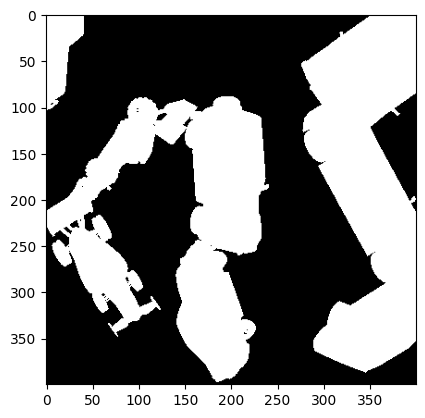

In [2]:
# code\UsefullnessOfDepth\datasets\foreground_background\SynthDet_cars_foreground_background_complex_texture_fgbg\labels\test_0.png
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open(r"..\datasets\foreground_background\SynthDet_cars_foreground_background_complex_texture_fgbg\labels\test_0.png")
image = np.array(image)

print(np.unique(image))
plt.imshow(image, cmap="gray")
plt.show()


In [41]:
import numpy as np
from scipy.linalg import sqrtm
from skimage.util import view_as_windows

def calculate_rmi(image_a, image_b, radius):
    # Step 1: Create vectors representing co-occurrences of pixels and their neighbors
    def create_vector(image, i, j, radius):
        neighbors = image[i-radius:i+radius+1, j-radius:j+radius+1].flatten()
        return neighbors

    # Calculate dimensions
    d = 2 * (2 * radius + 1) ** 2

    # Extract dimensions of images
    m, n, c = image_a.shape

    # Initialize list to store vectors
    vectors = []

    # Iterate through each corresponding pair of pixels
    for i in range(radius, m - radius):
        for j in range(radius, n - radius):
            vector_a = create_vector(image_a, i, j, radius)
            vector_b = create_vector(image_b, i, j, radius)
            vectors.append(np.concatenate((vector_a, vector_b)))

    # Convert vectors to numpy array
    points = np.array(vectors).T

    # Step 2: Subtract the mean
    mean_point = np.mean(points, axis=1, keepdims=True)
    centered_points = points - mean_point

    # Step 3: Calculate covariance matrix
    covariance_matrix = np.dot(centered_points, centered_points.T) / centered_points.shape[1]

    # Step 4: Estimate joint entropy
    joint_entropy = np.log(np.linalg.det((2 * np.pi * np.e) ** (d / 2) * np.linalg.det(covariance_matrix) ** 0.5))

    # Step 5: Estimate marginal entropies
    sub_matrix_size = d // 2
    ca = covariance_matrix[:sub_matrix_size, :sub_matrix_size]
    cb = covariance_matrix[sub_matrix_size:, sub_matrix_size:]
    marginal_entropy_a = np.log(np.linalg.det((2 * np.pi * np.e) ** (sub_matrix_size / 2) * np.linalg.det(ca) ** 0.5))
    marginal_entropy_b = np.log(np.linalg.det((2 * np.pi * np.e) ** (sub_matrix_size / 2) * np.linalg.det(cb) ** 0.5))

    # Step 6: Calculate RMI
    rmi = marginal_entropy_a + marginal_entropy_b - joint_entropy

    return rmi



In [42]:
rmi = calculate_rmi(rgb_image, depth_3c, 5)
print("RMI (RGB + Depth):", rmi)

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [13]:
rmi = calculate_rmi(depth_3c, depth_3c, 5)
print("RMI (Depth + Depth):", rmi)

RMI (Depth + Depth): 24.137106833559045


In [10]:
rmi = calculate_rmi(rgb_image, rgb_image, 5)
print("RMI (RGB + RGB):", rmi)

RMI (RGB + RGB): 15.685286521931067


In [44]:
import PIL.Image as Image
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mutual_info_score
import numpy as np

rgb_sunrgbd_path = r"..\datasets\SUNRGBD\RGB"
depth_sunrgbd_path = r"..\datasets\SUNRGBD\Depth"
label_sunrgbd_path = r"..\datasets\SUNRGBD\labels"

rgb_image_paths = [os.path.join(rgb_sunrgbd_path, f) for f in os.listdir(rgb_sunrgbd_path)]
depth_image_paths = [os.path.join(depth_sunrgbd_path, f) for f in os.listdir(depth_sunrgbd_path)]
label_paths = [os.path.join(label_sunrgbd_path, f) for f in os.listdir(label_sunrgbd_path)]
rgb_image_paths = sorted(rgb_image_paths)
depth_image_paths = sorted(depth_image_paths)
label_paths = sorted(label_paths)

def calculate_mutual_information(image_a, image_b):
    if image_a.shape[-1] == 3:
        image_a = image_a.mean(axis=-1)
    # Flatten the images
    image_a = image_a.flatten()
    image_b = image_b.flatten()

    # Calculate the mutual information
    mi = mutual_info_score(image_a, image_b)
    return mi



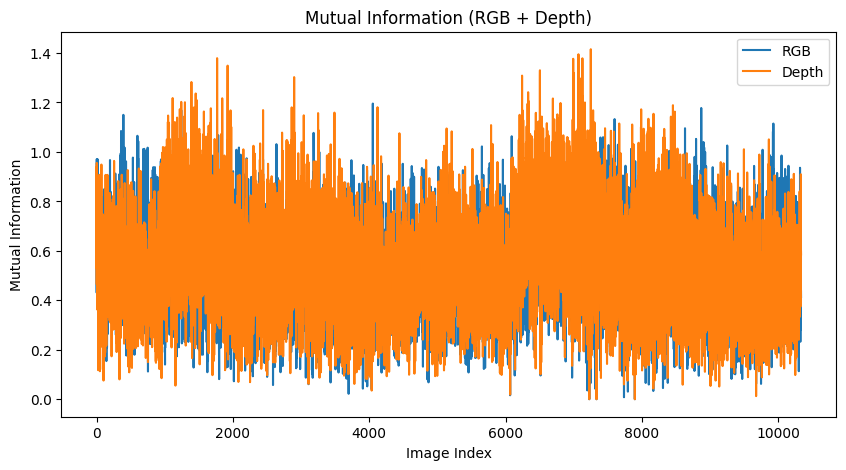

In [45]:
rgb_image_paths = rgb_image_paths
depth_image_paths = depth_image_paths

images_rgb = [np.array(Image.open(f)) for f in rgb_image_paths]
images_depth = [np.array(Image.open(f)) for f in depth_image_paths]
images_labels = [np.array(Image.open(f)) for f in label_paths]

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

mutual_information_rgb_label = [calculate_mutual_information(images_rgb[i], images_labels[i]) for i in range(len(images_rgb))]
mutual_information_depth_label = [calculate_mutual_information(images_depth[i], images_labels[i]) for i in range(len(images_depth))]

# Calculate the mutual information between RGB and depth images
plt.figure(figsize=(10, 5))
plt.plot(mutual_information_rgb_label, label="RGB")
plt.plot(mutual_information_depth_label, label="Depth")
plt.legend()
plt.title("Mutual Information (RGB + Depth)")
plt.xlabel("Image Index")
plt.ylabel("Mutual Information")
plt.show()

In [47]:
avg_mi_rgb = np.mean(mutual_information_rgb_label)
avg_mi_depth = np.mean(mutual_information_depth_label)
print("Average Mutual Information (RGB):", avg_mi_rgb)
print("Average Mutual Information (Depth):", avg_mi_depth)

Average Mutual Information (RGB): 0.5190674198216235
Average Mutual Information (Depth): 0.5513248461371251


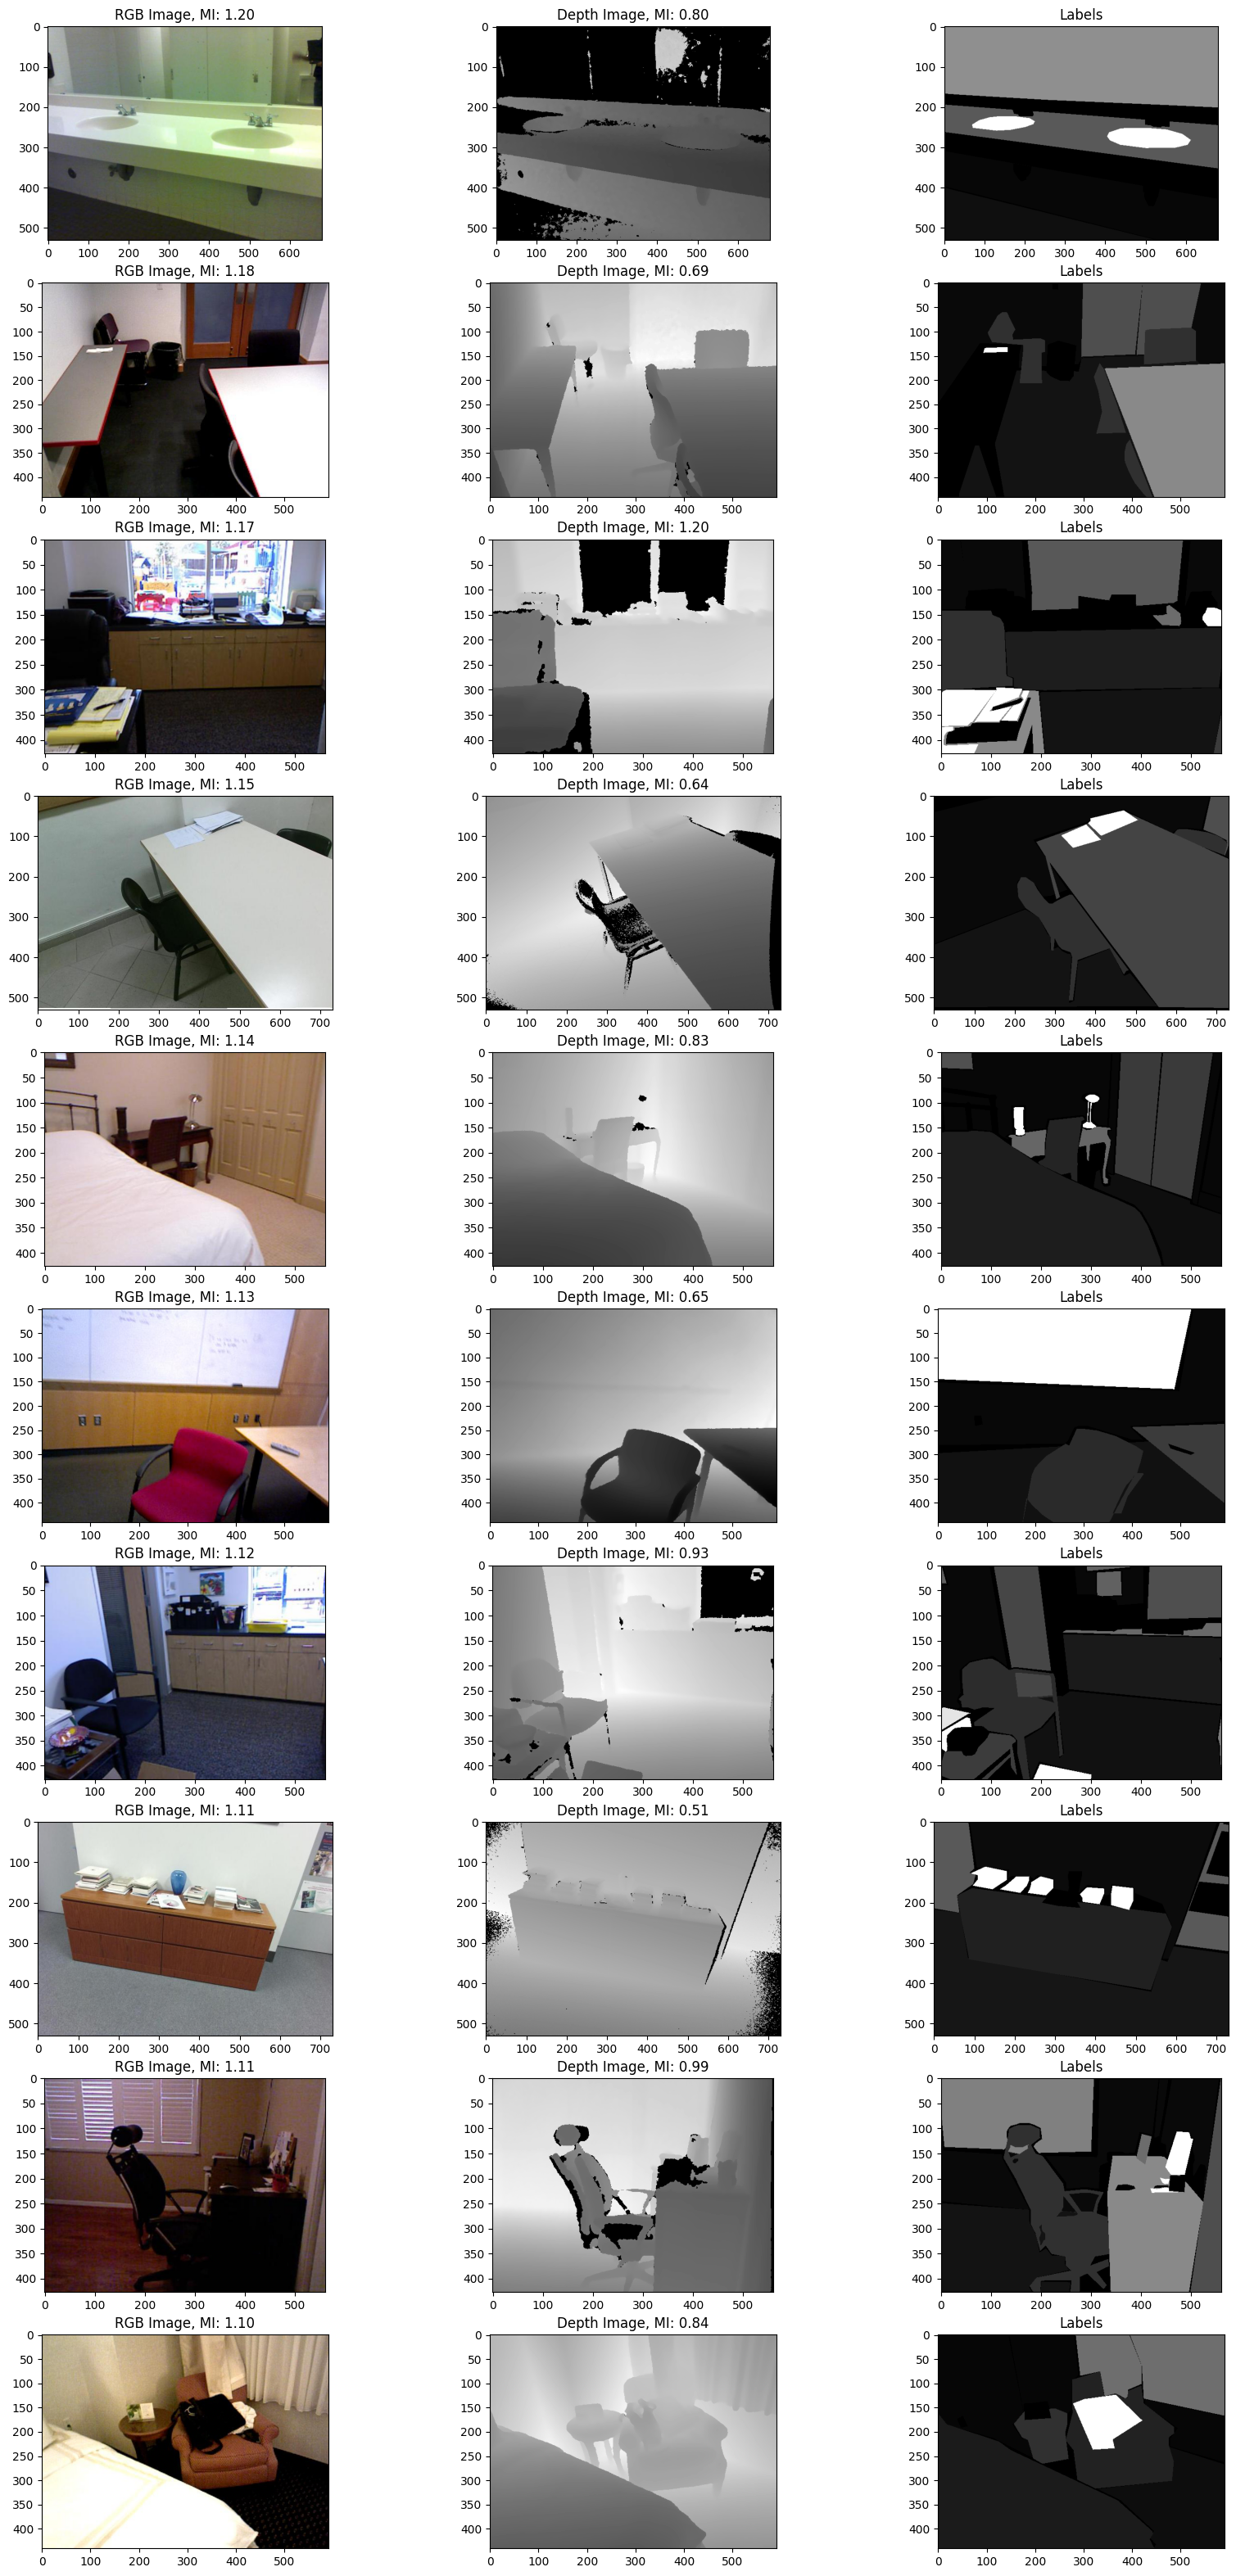

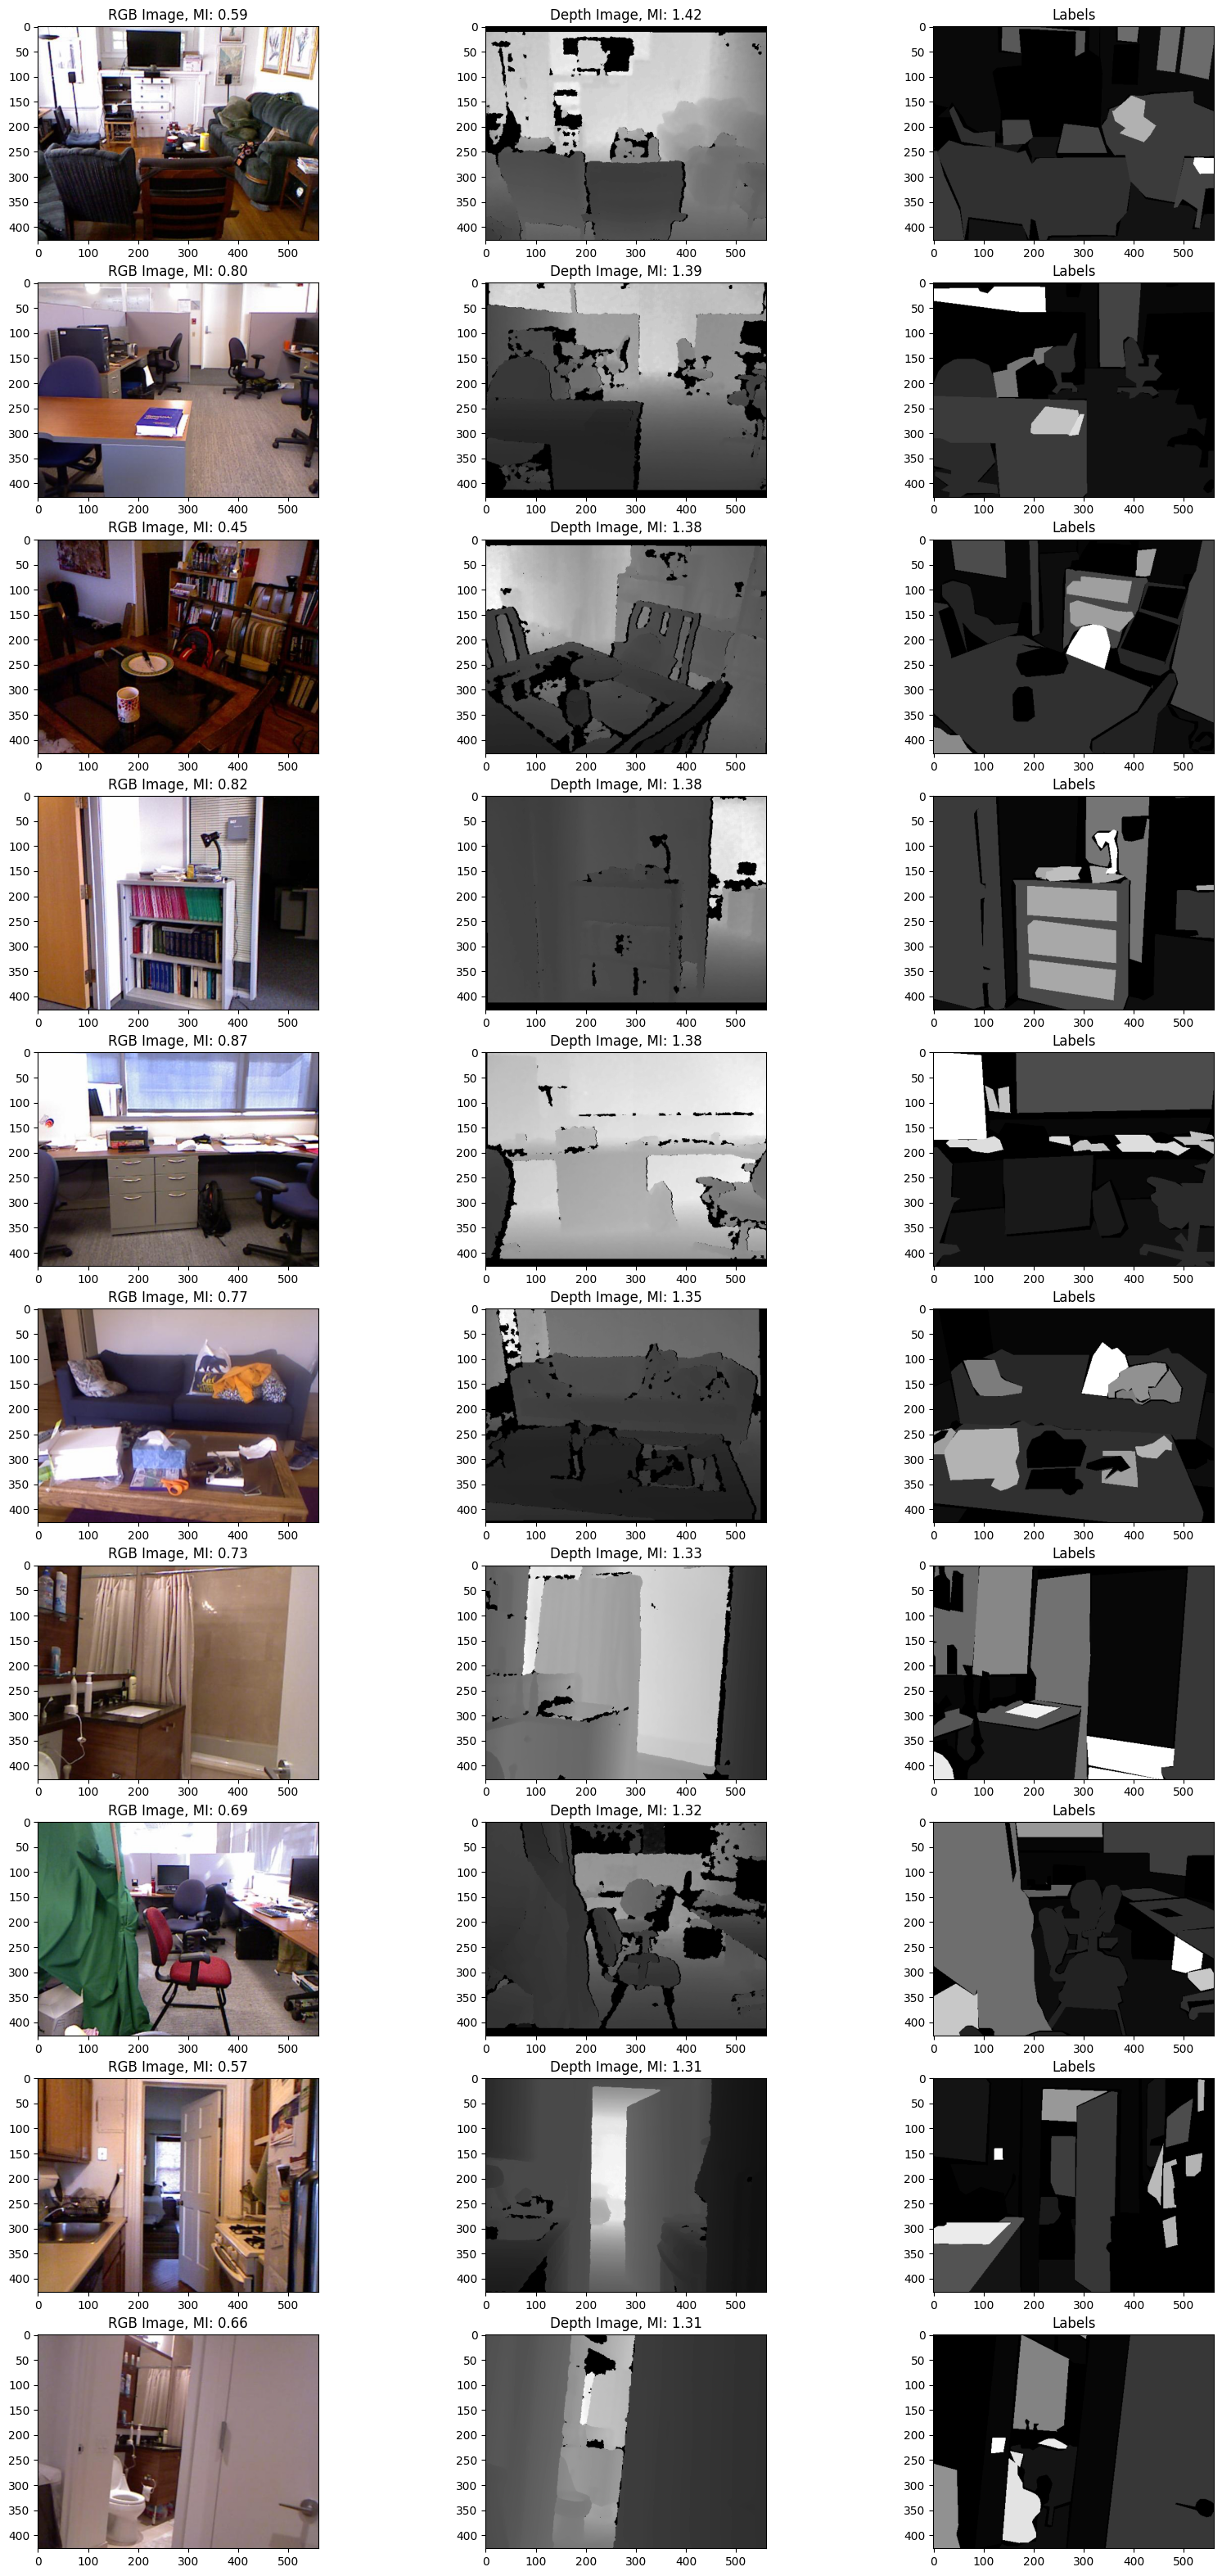

In [51]:
# Show 10 images where depth and the label have high mutual information
high_mi_depth_label = np.argsort(mutual_information_depth_label)[::-1][:10]
high_mi_rgb_label = np.argsort(mutual_information_rgb_label)[::-1][:10]

fig, ax = plt.subplots(10, 3, figsize=(20, 40))
for i in range(10):
    ax[i, 0].imshow(images_rgb[high_mi_rgb_label[i]])
    ax[i, 0].set_title("RGB Image, MI: {:.2f}".format(mutual_information_rgb_label[high_mi_rgb_label[i]]))
    ax[i, 1].imshow(images_depth[high_mi_rgb_label[i]], cmap="gray")
    ax[i, 1].set_title("Depth Image, MI: {:.2f}".format(mutual_information_depth_label[high_mi_rgb_label[i]]))
    ax[i, 2].imshow(images_labels[high_mi_rgb_label[i]], cmap="gray")
    ax[i, 2].set_title("Labels")

plt.show()

# Show 10 images where depth and the label have low mutual information
fig, ax = plt.subplots(10, 3, figsize=(20, 40))
for i in range(10):
    ax[i, 0].imshow(images_rgb[high_mi_depth_label[i]])
    ax[i, 0].set_title("RGB Image, MI: {:.2f}".format(mutual_information_rgb_label[high_mi_depth_label[i]]))
    ax[i, 1].imshow(images_depth[high_mi_depth_label[i]], cmap="gray")
    ax[i, 1].set_title("Depth Image, MI: {:.2f}".format(mutual_information_depth_label[high_mi_depth_label[i]]))
    ax[i, 2].imshow(images_labels[high_mi_depth_label[i]], cmap="gray")
    ax[i, 2].set_title("Labels")

plt.show()

In [12]:
# Utils
import sys
sys.path.append("../")
import os
import importlib
from PIL import Image

from utils.dataloader.dataloader import get_train_loader,get_val_loader
from utils.dataloader.RGBXDataset import RGBXDataset
import importlib
import torch
import matplotlib.pyplot as plt
import numpy as np

config_path = r"..\configs\SynthDet\SynthDet_template_DFormer_Tiny.py"
config_module = importlib.import_module("configs.SUNRGBD.SUNRGBD_DFormer_Tiny")
config = config_module.config

dataset_path = r"..\datasets\SUNRGBD"
rgb_root_folder = r"..\datasets\SUNRGBD\RGB"
gt_root_folder = r"..\datasets\SUNRGBD\labels"
x_root_folder = r"..\datasets\SUNRGBD\Depth"
train_source = r"..\datasets\SUNRGBD\train.txt"
eval_source = r"..\datasets\SUNRGBD\test.txt"

new_dataset_location = r"..\datasets\SynthDet_SUNRGBD_subset"
if not os.path.exists(new_dataset_location):
    os.makedirs(new_dataset_location)

if not os.path.exists(os.path.join(new_dataset_location, "RGB")):
    os.makedirs(os.path.join(new_dataset_location, "RGB"))

if not os.path.exists(os.path.join(new_dataset_location, "Depth")):
    os.makedirs(os.path.join(new_dataset_location, "Depth"))

if not os.path.exists(os.path.join(new_dataset_location, "labels")):
    os.makedirs(os.path.join(new_dataset_location, "labels"))

rgb_image_filenames = [f for f in os.listdir(rgb_root_folder)]
gt_image_filenames = [f for f in os.listdir(gt_root_folder)]
x_image_filenames = [f for f in os.listdir(x_root_folder)]

rgb_image_filenames = sorted(rgb_image_filenames)
gt_image_filenames = sorted(gt_image_filenames)
x_image_filenames = sorted(x_image_filenames)

for (rgb_image_filename, depth_image_filename, label_image_filename) in zip(rgb_image_filenames, x_image_filenames, gt_image_filenames):
    # rgb_image = Image.open(os.path.join(rgb_root_folder, rgb_image_filename))
    # depth_image = Image.open(os.path.join(x_root_folder, depth_image_filename))
    label_image = Image.open(os.path.join(gt_root_folder, label_image_filename))

    # rgb_image = np.array(rgb_image)
    # depth_image = np.array(depth_image)
    label_image = np.array(label_image)

    if 4 in np.unique(label_image):
        # new_rgb_image = Image.fromarray(rgb_image)
        # new_depth_image = Image.fromarray(depth_image)
        # new_label_image = Image.fromarray(label_image)

        # new_rgb_image.save(os.path.join(new_dataset_location, f"RGB/{rgb_image_filename}"))
        # new_depth_image.save(os.path.join(new_dataset_location, f"Depth/{depth_image_filename}"))
        # new_label_image.save(os.path.join(new_dataset_location, f"labels/{label_image_filename}"))


        if "train" in rgb_image_filename:
            with open(os.path.join(new_dataset_location, "train.txt"), "a") as f:
                f.write(f"RGB/{rgb_image_filename} labels/{label_image_filename}\n")
        else:
            with open(os.path.join(new_dataset_location, "test.txt"), "a") as f:
                f.write(f"RGB/{rgb_image_filename} labels/{label_image_filename}\n")

    

In [4]:
import numpy as np
datarange = np.linspace(0.001, 5, 10)
datarange

array([1.00000000e-03, 5.56444444e-01, 1.11188889e+00, 1.66733333e+00,
       2.22277778e+00, 2.77822222e+00, 3.33366667e+00, 3.88911111e+00,
       4.44455556e+00, 5.00000000e+00])

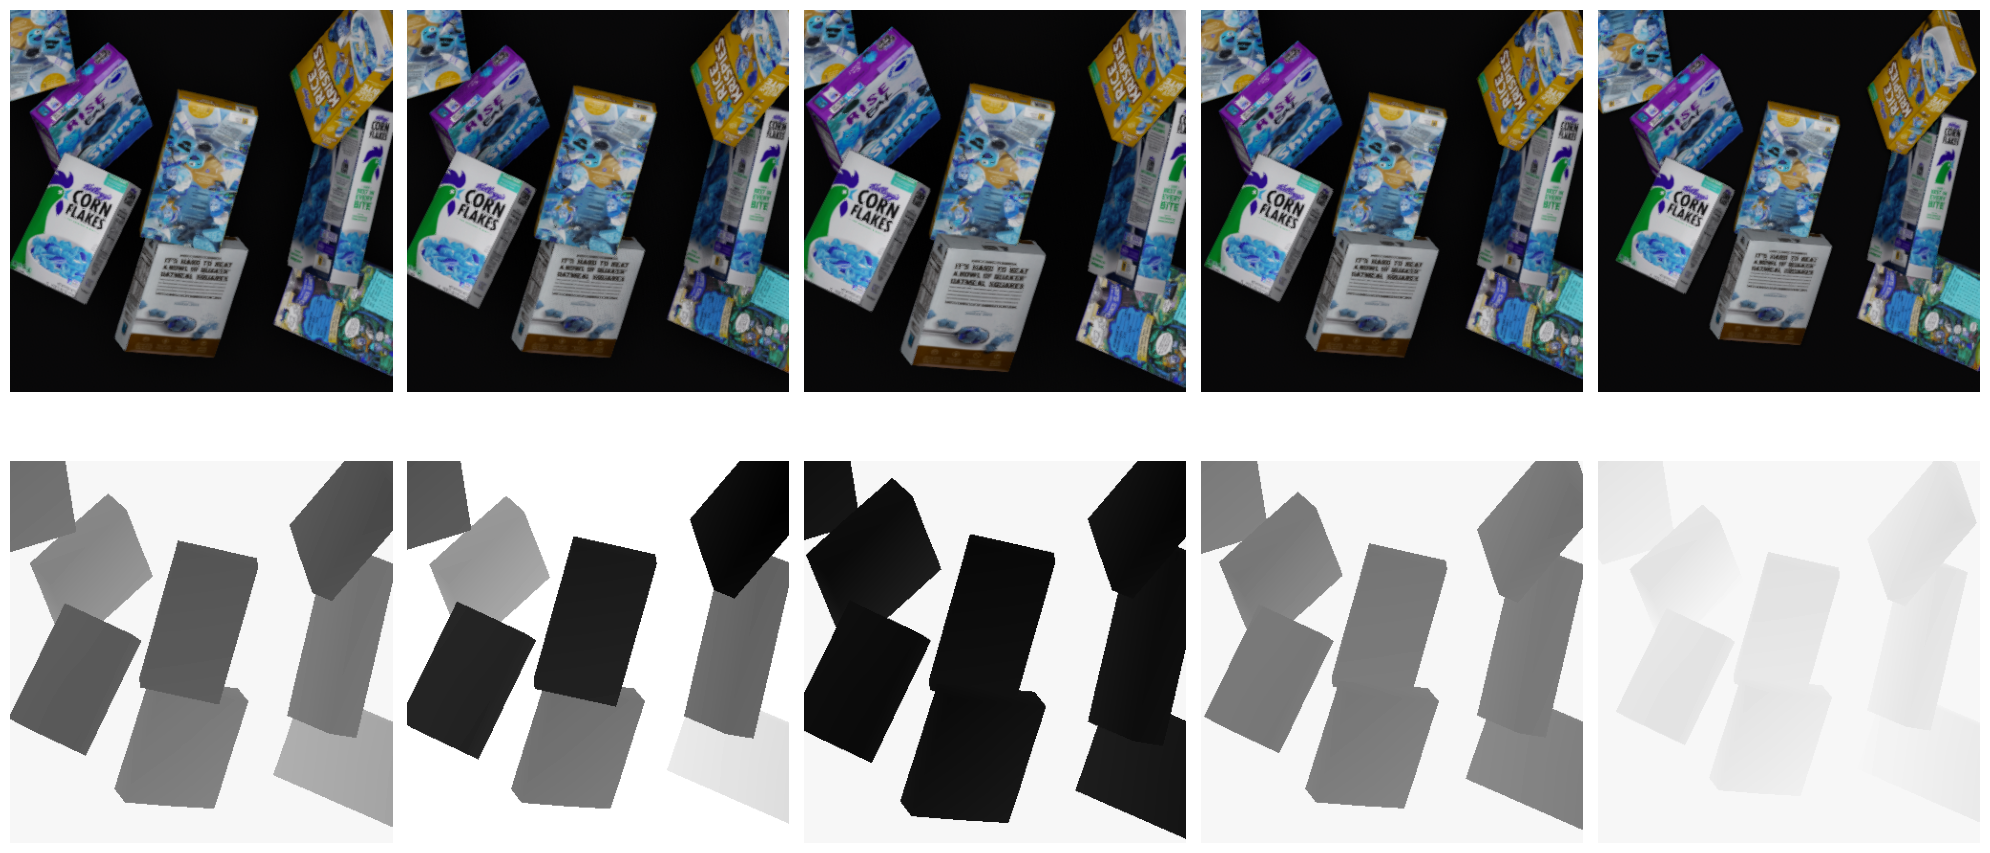

In [9]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# code\UsefullnessOfDepth\datasets\spatial\SynthDet_groceries_spatial_large_depth
spatial_large_path = r"..\datasets\spatial\SynthDet_groceries_spatial_large_depth"
spatial_medium_path = r"..\datasets\spatial\SynthDet_groceries_spatial_medium_depth"
spatial_small_close_path = r"..\datasets\spatial\SynthDet_groceries_spatial_small_depth_close"
spatial_small_far_path = r"..\datasets\spatial\SynthDet_groceries_spatial_small_depth_far"
spatial_small_avg_path = r"..\datasets\spatial\SynthDet_groceries_spatial_small_depth_avg"

depth_folder = "Depth"
RGB_folder = "RGB"
test_image = "test_0.png"

fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i, path in enumerate([spatial_medium_path, spatial_large_path, spatial_small_close_path, spatial_small_avg_path, spatial_small_far_path]):
    depth_image = cv2.imread(os.path.join(path, depth_folder, test_image), cv2.IMREAD_UNCHANGED)
    rgb_image = cv2.imread(os.path.join(path, RGB_folder, test_image), cv2.IMREAD_UNCHANGED)

    ax[0, i].imshow(rgb_image)
    ax[0, i].axis("off")

    ax[1, i].imshow(depth_image, cmap="gray", vmin=0, vmax=255)
    ax[1, i].axis("off")

plt.tight_layout()
plt.show()


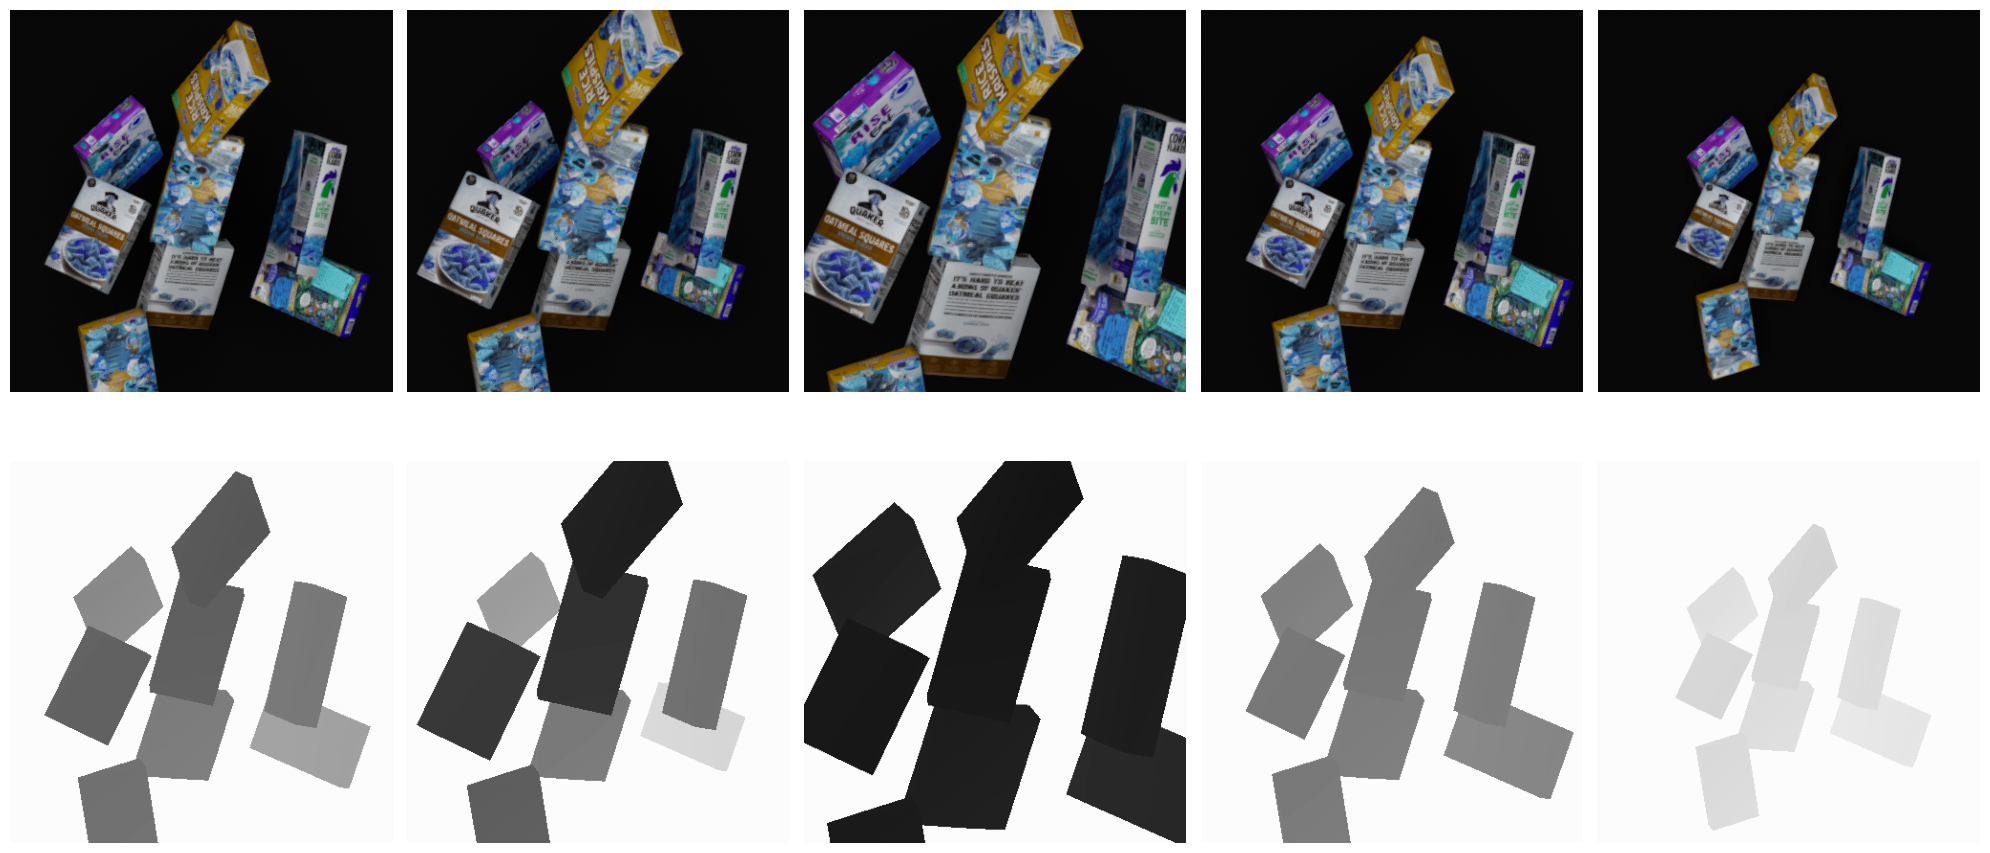

In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# code\UsefullnessOfDepth\datasets\spatial\SynthDet_groceries_spatial_large_depth
spatial_large_path =        r"..\datasets\spatial\SynthDet_groceries_spatial_realistic_large"
spatial_medium_path =       r"..\datasets\spatial\SynthDet_groceries_spatial_realistic_medium"
spatial_small_close_path =  r"..\datasets\spatial\SynthDet_groceries_spatial_realistic_close"
spatial_small_far_path =    r"..\datasets\spatial\SynthDet_groceries_spatial_realistic_far"
spatial_small_avg_path =    r"..\datasets\spatial\SynthDet_groceries_spatial_realistic_half"

depth_folder = "Depth"
RGB_folder = "RGB"
test_image = "test_0.png"

fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i, path in enumerate([spatial_medium_path, spatial_large_path, spatial_small_close_path, spatial_small_avg_path, spatial_small_far_path]):
    depth_image = cv2.imread(os.path.join(path, depth_folder, test_image), cv2.IMREAD_UNCHANGED)
    rgb_image = cv2.imread(os.path.join(path, RGB_folder, test_image), cv2.IMREAD_UNCHANGED)

    ax[0, i].imshow(rgb_image)
    ax[0, i].axis("off")

    ax[1, i].imshow(depth_image, cmap="gray", vmin=0, vmax=255)
    ax[1, i].axis("off")

plt.tight_layout()
plt.show()

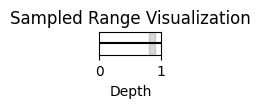

In [4]:
import matplotlib.pyplot as plt

# Define the range
depth_range = [0, 1]
sampled_range = [0.8, 0.9]

# Plotting
plt.figure(figsize=(0.8, 0.3))

# Plot the horizontal line from 0 to 1
plt.plot([depth_range[0], depth_range[1]], [0, 0], color='black')

# Shade the area representing the sampled range
plt.fill_betweenx(y=[-0.1, 0.1], x1=sampled_range[0], x2=sampled_range[1], color='gray', alpha=0.3)

# Set labels and title
plt.xlim(depth_range)
plt.ylim(-0.1, 0.1)
plt.xlabel('Depth')
plt.title('Sampled Range Visualization')

# Hide y-axis ticks and labels
plt.yticks([])

plt.show()

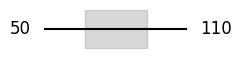

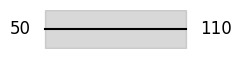

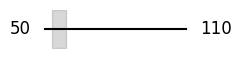

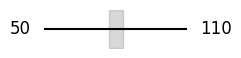

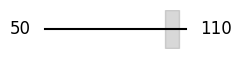

In [5]:
import matplotlib.pyplot as plt

# Define the range

sampled_ranges = [[0.28, 0.72], [0, 1], [0.05, 0.15], [0.45, 0.55], [0.85, 0.95]]
def plot_sample_range(sampled_range):
    depth_range = [0, 1]

    # Plotting
    plt.figure(figsize=(2, 0.5))

    # Plot the horizontal line from 0 to 1
    plt.plot([depth_range[0], depth_range[1]], [0, 0], color='black')

    # Shade the area representing the sampled range
    plt.fill_betweenx(y=[-0.1, 0.1], x1=sampled_range[0], x2=sampled_range[1], color='gray', alpha=0.3)

    # Set labels and title
    plt.ylim(-0.1, 0.1)

    # Hide y-axis ticks and labels
    plt.yticks([])
    plt.axis('off')

    # Add depth labels slightly outside the plot
    label_offset = 0.1
    plt.text(depth_range[0] - label_offset, 0, '50', ha='right', va='center', fontsize=12)
    plt.text(depth_range[1] + label_offset, 0, '110', ha='left', va='center', fontsize=12)

    plt.show()

for sampled_range in sampled_ranges:
    plot_sample_range(sampled_range)


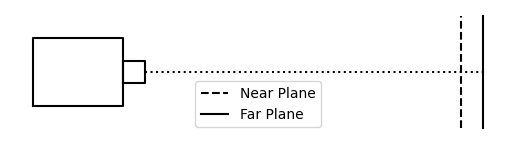

In [16]:
import matplotlib.pyplot as plt

# Function to plot the camera
def plot_camera():
    # Camera body
    plt.plot([0, 0, 4, 4, 0], [0, 3, 3, 0, 0], color='black')

    # Lens
    # plt.plot([4, 5, 5, 4, 4], [3, 3, 4, 4, 3], color='black')
    plt.plot([4, 5, 5, 4, 4], [1, 1, 2, 2, 1], color='black')

    # Near plane
    plt.plot([19, 19], [-1, 4], linestyle='dashed', color='black', label='Near Plane')

    # Far plane
    plt.plot([20, 20], [-1, 4], linestyle='solid', color='black', label='Far Plane')

    # Line from lens to near plane
    plt.plot([5, 20], [1.5, 1.5], linestyle='dotted', color='black')

    # Set axis limits and aspect ratio
    # plt.xlim(-1, 12)
    # plt.ylim(-1, 7)
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    # plt.title('2D Representation of Camera')
    plt.axis('off')
    plt.legend()

    plt.show()

# Plot the camera
plot_camera()



In [19]:
import numpy as np
import cv2

def salt_and_pepper_noise(image, salt_prob, pepper_prob):
    noisy_image = np.copy(image)
    row, col, _ = noisy_image.shape
    # Salt noise
    num_salt = np.ceil(salt_prob * row * col)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in noisy_image.shape]
    noisy_image[coords[0], coords[1], :] = 1

    # Pepper noise
    num_pepper = np.ceil(pepper_prob * row * col)
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in noisy_image.shape]
    noisy_image[coords[0], coords[1], :] = 0
    return noisy_image

# Load your RGB image
image = cv2.imread(r"..\datasets\SynthDet_rgb\RGB\test_0.png")  # Make sure your image has dimensions 400x400x3
# Normalize pixel values to range [0, 1]
image = image.astype(np.float32) / 255.0

# Apply salt and pepper noise with probabilities 0.01 and 0.01 for salt and pepper respectively
salt_prob = 0.01
pepper_prob = 0.01
noisy_image = salt_and_pepper_noise(image, salt_prob, pepper_prob)

# Convert the noisy image back to uint8 format
noisy_image_uint8 = (noisy_image * 255).astype(np.uint8)

# Display the noisy image
cv2.imshow('Noisy Image', noisy_image_uint8)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [20]:
import numpy as np
import cv2

def salt_and_pepper_noise(image, salt_distance=20, pepper_distance=25):
    noisy_image = np.copy(image)
    row, col, _ = noisy_image.shape

    # Calculate number of salt and pepper clusters based on distance factor
    salt_clusters = int((row * col) / (salt_distance**2))
    pepper_clusters = int((row * col) / (pepper_distance**2))

    # Add salt noise clusters
    for _ in range(salt_clusters):
        cluster_size = np.random.randint(5, 20)  # Random cluster size between 5 and 20
        rand_row = np.random.randint(0, row - cluster_size)
        rand_col = np.random.randint(0, col - cluster_size)
        noisy_image[rand_row:rand_row+cluster_size, rand_col:rand_col+cluster_size, :] = 1

    # Add pepper noise clusters
    for _ in range(pepper_clusters):
        cluster_size = np.random.randint(5, 20)  # Random cluster size between 5 and 20
        rand_row = np.random.randint(0, row - cluster_size)
        rand_col = np.random.randint(0, col - cluster_size)
        noisy_image[rand_row:rand_row+cluster_size, rand_col:rand_col+cluster_size, :] = 0

    return noisy_image

# Load your RGB image
image = cv2.imread(r"..\datasets\SynthDet_rgb\RGB\test_0.png")  # Make sure your image has dimensions 400x400x3
# Normalize pixel values to range [0, 1]
image = image.astype(np.float32) / 255.0

# Apply salt and pepper noise with distance factors of 20 and 25 for salt and pepper respectively
salt_distance = 20
pepper_distance = 25
noisy_image = salt_and_pepper_noise(image, salt_distance, pepper_distance)

# Convert the noisy image back to uint8 format
noisy_image_uint8 = (noisy_image * 255).astype(np.uint8)

# Display the noisy image
cv2.imshow('Noisy Image', noisy_image_uint8)
cv2.waitKey(0)
cv2.destroyAllWindows()
